### **Import Libraries**

In [1]:
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset
import warnings
from functools import partial
from datasets import concatenate_datasets, DatasetDict
from functools import partial 
from IPython.display import display
from IPython.display import Markdown
import textwrap
from transformers import pipeline
from trl import SFTTrainer
# Filter out the specific warning
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Plotting**

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')
from matplotlib import font_manager 
locations =  './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-LightItalic.ttf


#### **Key Parameters**

In [3]:
# This cell is tagged with `parameters`
model_name = 'distilbert-base-cased'
data_link = 'ppower1/instrument'
casusal_variable = True 
column = 'text'
num_epochs = 10
seed = 2 
test_size = 0.5

#### **Helper Functions**

In [4]:
def preprocess_function(examples, column='text', padding=True):
    tokenized = tokenizer(examples[column], truncation=True, padding=padding, max_length=512)
    return {**tokenized, 'label': examples['label']}

def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### ---         Memory Check
def Memory():
    print("Current memory usage:")
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
### ---

def add_is_train_column(batch):
    # Length of the batch
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    # Create a list with the same value for all elements in the batch
    batch['is_train'] = [1] * batch_size
    return batch

# Modify the function for the test set
def add_is_test_column(batch):
    batch_size = len(batch['text'])  # Replace 'column_name' with the name of one of your columns
    batch['is_train'] = [0] * batch_size
    return batch

def remove_substring(example):
    # The string to be removed
    substring1 = "True or False: The Right to Counsel is in effect in the tenant's zip code."
    substring2 = "True or False: The tenant has legal representation."
    # Replace the substring with an empty string
    example["text"] = example["text"].replace(substring1, "")
    example["text"] = example["text"].replace(substring2, "")

    try:
        example["treated text"] = example["treated text"].replace(substring1, "")
        example["treated text"] = example["treated text"].replace(substring2, "")
        example["control text"] = example["control text"].replace(substring1, "")
        example["control text"] = example["control text"].replace(substring2, "")
    
    except KeyError as e:
        assert casusal_variable == False 


    return example

### ---         Print Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
### ---

#### **Model**

In [5]:
Memory()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)
Memory()

Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Current memory usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
import pandas as pd
unmasker = pipeline('fill-mask', model='roberta-base')
display(pd.DataFrame(unmasker("The white tenat was evicted because she <mask>.")))
display(pd.DataFrame(unmasker("The black tenat was evicted because she <mask>.")))

,score,token,token_str,sequence
0,0.105842,20934,objected,The white tenat was evicted because she objected.
1,0.089837,7311,complained,The white tenat was evicted because she compla...
2,0.070737,3179,refused,The white tenat was evicted because she refused.
3,0.060797,17278,protested,The white tenat was evicted because she protes...
4,0.050921,19894,smoked,The white tenat was evicted because she smoked.


,score,token,token_str,sequence
0,0.067677,20934,objected,The black tenat was evicted because she objected.
1,0.065904,3179,refused,The black tenat was evicted because she refused.
2,0.063993,19894,smoked,The black tenat was evicted because she smoked.
3,0.060058,7311,complained,The black tenat was evicted because she compla...
4,0.054462,2075,ran,The black tenat was evicted because she ran.


#### **Load Data**

In [7]:
# Load Dataset 
original_dataset = load_dataset(data_link)['train']
print(np.mean(original_dataset['label']))

Using the latest cached version of the dataset since ppower1/instrument couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/ubuntu/.cache/huggingface/datasets/ppower1___instrument/default/0.0.0/d5124e861a48930eb9307e429b91777ba490f8e1 (last modified on Mon Apr 22 12:33:28 2024).


0.06359089517199143


In [8]:
num_tokens = original_dataset.map(count_tokens)['num_tokens']
max_length = max(num_tokens)
print(f'Max Length:  {max_length}')
print(len(num_tokens))

Map:   0%|          | 0/9797 [00:00<?, ? examples/s]

Max Length:  1016
9797


#### **Tokens Count**

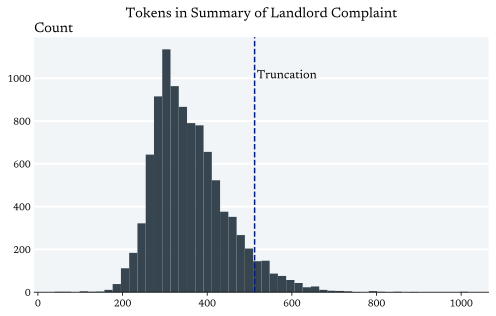

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
ax.set_title('Tokens in Summary of Landlord Complaint', size=14, loc='center', pad=20)

plt.hist(num_tokens, bins=50, color='#36454F')
plt.axvline(512, linestyle='--')
ax.annotate(f'Truncation',
                xy = (0.49, 0.85),
                xycoords='axes fraction',
                ha='left',
                va="center", 
                size=12)
plt.show()

#### **Clean Data**

In [10]:
# Shuffle the dataset
original_dataset = original_dataset.shuffle(seed=3)

# Select the first 1000 samples
original_dataset = original_dataset.select(range(200))
print(np.mean(original_dataset['label']))

# Remove Unnecessary Trailing String
original_dataset = original_dataset.map(remove_substring)
print(original_dataset)

# Add Index Column
original_dataset = original_dataset.add_column("original_index", range(len(original_dataset)))

0.06
Dataset({
    features: ['text', 'treated text', 'control text', 'raw_label', 'label'],
    num_rows: 200
})


#### **Train Test Split**

In [11]:
# Split Data Set
dataset = original_dataset.train_test_split(test_size=test_size, seed=seed)

# Mark each dataset with train/test ids
dataset['train'] = dataset['train'].map(add_is_train_column, batched=True)
dataset['test'] = dataset['test'].map(add_is_test_column, batched=True)

# Tokenize Dataset 
tokenized_dataset = dataset.map(partial(preprocess_function, column=column), batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

#### **Recombine Dataset**

In [12]:
# Combine and Resort Train/Test data sets
combined_dataset = concatenate_datasets([dataset['train'], dataset['test']])
combined_dataset = combined_dataset.sort("original_index")

# Tokenize the combined dataset
tokenized_original_dataset = combined_dataset.map(partial(preprocess_function, column=column), batched=True)
tokenized_treated_dataset = combined_dataset.map(partial(preprocess_function, column='treated text'), batched=True)
tokenized_control_dataset =  combined_dataset.map(partial(preprocess_function, column='control text'), batched=True)

#### **Hyperparameters**

In [13]:
metric = evaluate.load("accuracy")

def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-4,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        load_best_model_at_end=True,
        evaluation_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        #lr_scheduler_type='' #  https://stackoverflow.com/questions/77792137/how-to-fix-the-learning-rate-for-huggingface%C2%B4s-trainer
)

KeyboardInterrupt: 

In [ ]:
# To get the initial training loss
trainer = Trainer(model=model,
                args=get_training_args("test_trainer"),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["train"],
                compute_metrics=compute_metrics)

init_train_eval = trainer.evaluate()
init_train_loss = init_train_eval['eval_loss']
init_train_accuracy = init_train_eval['eval_accuracy']
print(f"Initial Training Loss: {init_train_loss:.4f}    |   Initial Training Accuracy: {init_train_accuracy:.4f}")

In [ ]:
# Actual Trainer
model.eval()
trainer = Trainer(
                model=model,
                args=get_training_args('output_dir'),
                train_dataset=tokenized_dataset["train"],
                eval_dataset=tokenized_dataset["test"],
                compute_metrics=compute_metrics)

init_eval_eval = trainer.evaluate()
init_eval_loss = init_eval_eval['eval_loss']
init_eval_accuracy = init_eval_eval['eval_accuracy']
print(f"Initial Evaluation Loss: {init_eval_loss:.4f}    |   Initial Evaluation Accuracy: {init_eval_accuracy:.4f}")

In [ ]:
# Train
trainer.train()

In [ ]:
steps, train_loss = [0] + [i['step'] for i in trainer.state.log_history if 'loss' in i], [init_train_loss] + [i['loss'] for i in trainer.state.log_history if 'loss' in i]
_, eval_loss = [i['step'] for i in trainer.state.log_history if 'eval_loss' in i], [init_eval_loss] + [i['eval_loss'] for i in trainer.state.log_history if 'eval_loss' in i]
eval_accuracy = [init_eval_accuracy] + [i['eval_accuracy'] for i in trainer.state.log_history if 'eval_accuracy' in i]
lr = [i['learning_rate'] for i in trainer.state.log_history if 'learning_rate' in i]

In [ ]:
plt.plot(lr)
plt.show()

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation loss')
plt.plot(eval_accuracy, label='Accuracy')
plt.legend()
plt.show()

In [ ]:
original_dataset[:10]

In [ ]:
inputs = tokenizer(original_dataset['text'][0], return_tensors='pt').to('cuda')

In [ ]:
original_predictions

In [ ]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_original_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    treated_predictions = trainer.predict(tokenized_treated_dataset).predictions
    treated_predictions = torch.nn.functional.softmax(torch.tensor(treated_predictions), dim=1)[:,1].numpy()

with torch.no_grad():
    control_predictions = trainer.predict(tokenized_control_dataset).predictions
    control_predictions = torch.nn.functional.softmax(torch.tensor(control_predictions), dim=1)[:,1].numpy()

In [ ]:
treated_predictions - control_predictions

In [ ]:
plt.hist(original_predictions)
plt.xlim(-1,1)
plt.show()

In [ ]:
results = np.hstack((np.array(tokenized_original_dataset['is_train']).reshape(-1,1), original_predictions.reshape(-1,1), treated_predictions.reshape(-1,1), control_predictions.reshape(-1,1) ))

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Effect', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist((treated_predictions - control_predictions).reshape(-1,), color='#36454F', density=True, bins=30)
plt.show()

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Effect', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.scatter(control_predictions.reshape(-1,), (treated_predictions - control_predictions).reshape(-1,), color='#36454F')
plt.xlim(0, .15)
plt.xlabel("Probability of Outcome Without Instrment", size=12)
plt.show()

In [ ]:
os.getcwd()

#### **Clean Up**

In [ ]:
!rm -rf ./output_dir

In [ ]:
!rm -rf ./synth_evict/